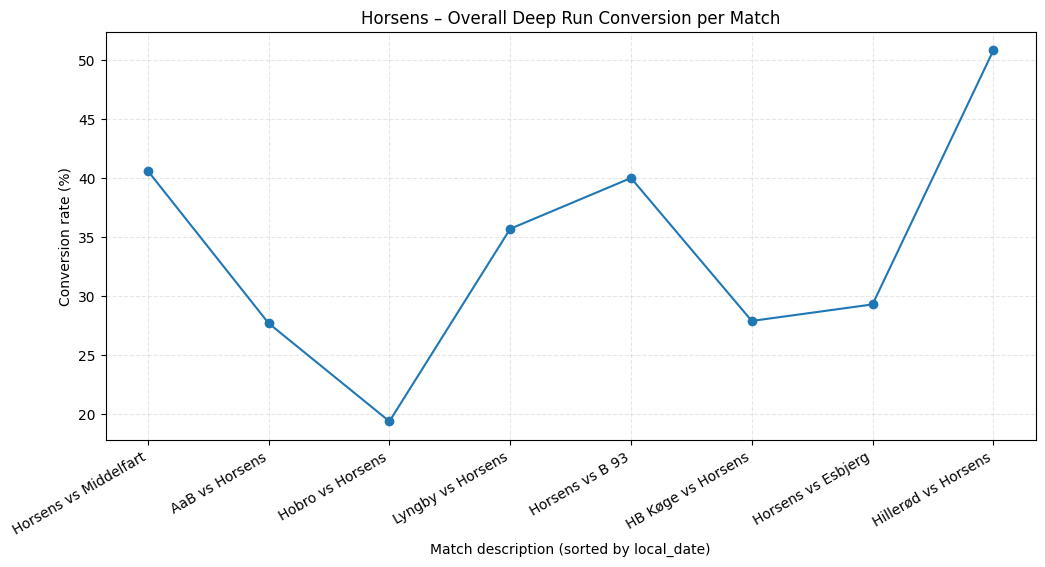


=== Overall (last 4 matches) ===
         Team  Opportunities / match  Deep runs / match  Conversion rate (%)
      Kolding                   59.0               24.0                 40.8
          AaB                   84.8               32.2                 38.4
      Horsens                   55.5               20.5                 37.0
   Middelfart                   75.8               26.8                 36.5
         B_93                   93.5               33.2                 35.6
       Lyngby                   66.5               23.5                 34.4
     Hvidovre                   45.0               14.8                 32.8
        Hobro                   74.0               24.0                 32.0
      Esbjerg                   71.8               22.2                 30.7
     Hillerød                   78.0               22.0                 26.3
      HB_Køge                   56.2               14.5                 26.2
Aarhus_Fremad                   84.2      

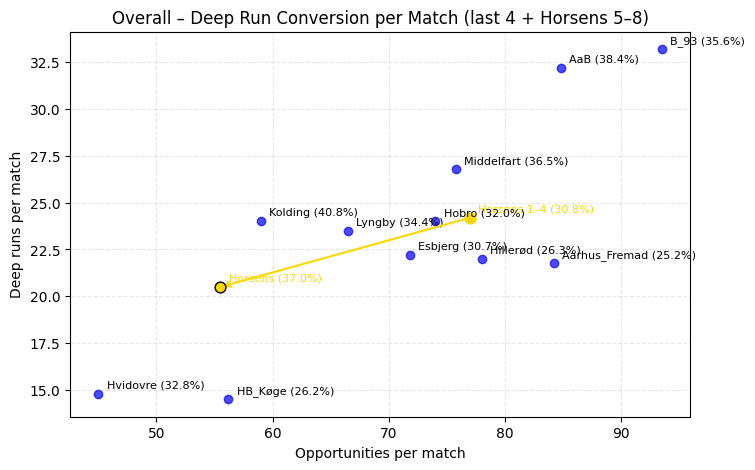


=== High base (last 4 matches) ===
         Team  Opportunities / match  Deep runs / match  Conversion rate (%)
          AaB                   49.0               20.0                 45.4
      Kolding                   35.2               13.0                 36.6
         B_93                   53.8               19.0                 35.4
     Hvidovre                   20.5                6.5                 31.6
      Horsens                   31.8                9.0                 27.8
   Middelfart                   44.2               11.2                 25.3
      Esbjerg                   41.5                9.8                 24.2
      HB_Køge                   30.5                7.2                 22.8
       Lyngby                   38.5                8.8                 22.8
        Hobro                   42.8                9.2                 21.9
Aarhus_Fremad                   46.0                9.2                 20.2
     Hillerød                   44.2    

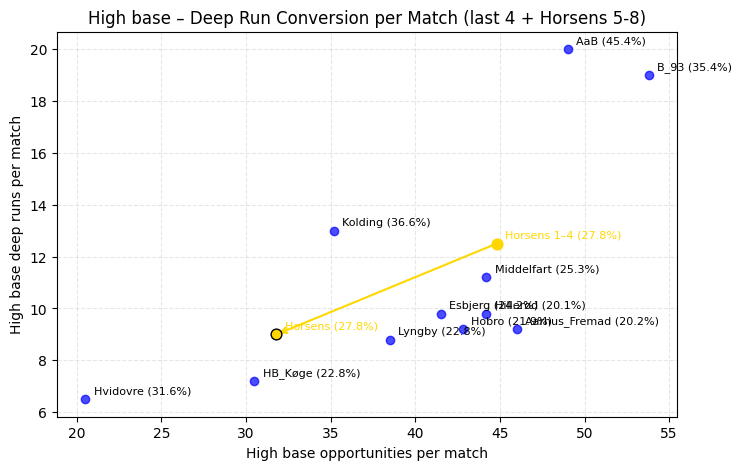


=== Pocket (last 4 matches) ===
         Team  Opportunities / match  Deep runs / match  Conversion rate (%)
     Hvidovre                   14.8                8.8                 68.4
       Lyngby                   15.5               11.2                 68.0
      Horsens                   12.5                8.2                 66.9
   Middelfart                   17.2               10.8                 61.6
      Kolding                   15.0                9.0                 59.5
        Hobro                   15.0                9.0                 58.9
         B_93                   17.2                9.5                 57.9
     Hillerød                   18.2               10.2                 54.1
      Esbjerg                   12.8                5.8                 44.1
          AaB                   17.0                8.8                 39.7
      HB_Køge                   12.8                5.0                 38.0
Aarhus_Fremad                   17.5       

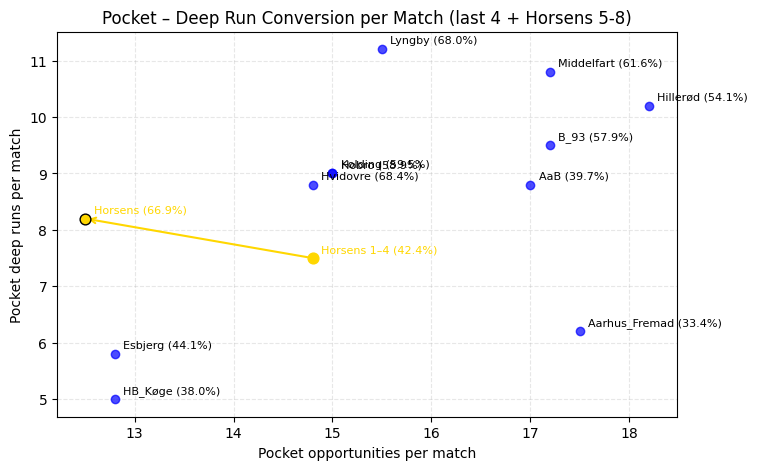


=== Width (last 4 matches) ===
         Team  Opportunities / match  Deep runs / match  Conversion rate (%)
   Middelfart                   22.0                9.2                 46.0
      Kolding                   15.2                5.0                 36.9
         B_93                   30.8               11.2                 36.5
        Hobro                   22.5                9.5                 36.2
          AaB                   28.5               10.2                 35.6
      Horsens                   18.0                5.8                 32.4
      Esbjerg                   27.2               10.0                 31.9
Aarhus_Fremad                   32.5                9.8                 28.9
       Lyngby                   20.5                6.2                 28.5
      HB_Køge                   19.5                4.5                 24.0
     Hillerød                   24.2                6.2                 23.5
     Hvidovre                   15.2        

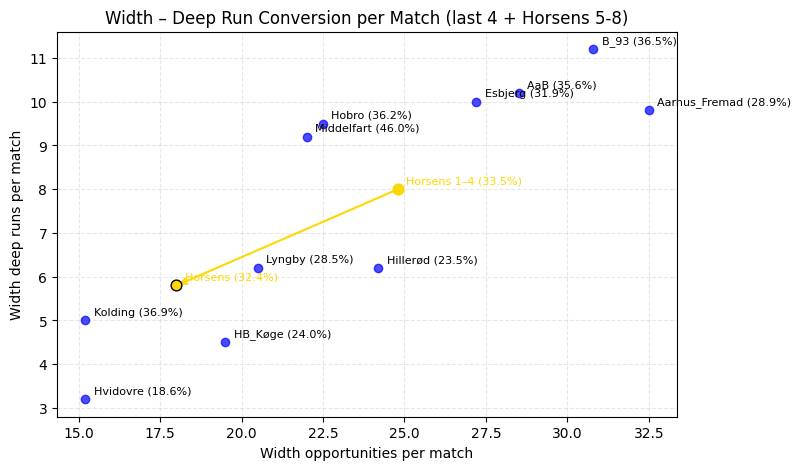

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# -------- CONFIG --------
BASE_PATH = r"C:\Users\Seamus-admin\Documents\GitHub\AC-Horsens-First-Team\DNK_1_Division_2025_2026"
USE_STREAMLIT = False  # set True if running inside Streamlit

if USE_STREAMLIT:
    import streamlit as st

# -------- LOADING --------
def load_all_teams(base_path: str, n_last_matches: int = 4) -> pd.DataFrame:
    teams = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    dfs = []
    for team in teams:
        file_path = os.path.join(base_path, team, f"{team}_on_ball_sequences.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df["team"] = team
            dfs.append(df)

    if not dfs:
        raise FileNotFoundError("No team CSVs found under the base path.")

    df_all = pd.concat(dfs, ignore_index=True)

    # ensure datetime
    df_all["local_date"] = pd.to_datetime(df_all["local_date"], errors="coerce")

    # compute the last N unique dates per team
    lastN_per_team = (
        df_all[["team", "local_date"]]
        .drop_duplicates()
        .sort_values(["team", "local_date"], ascending=[True, False])
    )
    lastN_per_team["date_rank"] = lastN_per_team.groupby("team")["local_date"] \
                                               .rank(method="dense", ascending=False)

    keep_dates = lastN_per_team[lastN_per_team["date_rank"] <= n_last_matches][["team", "local_date"]]

    # filter original to those dates per team
    df_filtered = df_all.merge(keep_dates, on=["team", "local_date"], how="inner")
    return df_filtered
# -------- CORE CALC HELPERS --------
def _mask_for_concept(df: pd.DataFrame, concept: str | None):
    """Return mask for: (concept True) AND (deep_run_opportunity True).
       If concept is None, use OR across High base, Pocket, Width.
    """
    if concept is None:
        concept_mask = (df["High base"] == True) | (df["Pocket"] == True) | (df["Width"] == True)
    else:
        concept_mask = (df[concept] == True)
    opportunity_mask = (df["deep_run_opportunity"] == True)
    return concept_mask & opportunity_mask

def per_match_summary(df: pd.DataFrame, concept: str | None = None) -> pd.DataFrame:
    """
    Build per-match summary for a given concept (or overall if concept=None):
      - opportunities: unique (sequence_id, match_id, team)
      - deep_runs: all rows with deep_run==True
      - conversion per match
    Returns one row per (team, match_id).
    """
    mask = _mask_for_concept(df, concept)

    # Unique opportunities (dedupe by sequence & match & team)
    opps_per_match = (
        df[mask]
        .drop_duplicates(subset=["sequence_id", "match_id", "team"])
        .groupby(["team", "match_id"])
        .size()
        .reset_index(name="opportunities")
    )

    # All deep runs (no dedupe)
    runs_per_match = (
        df[mask & (df["deep_run"] == True)]
        .groupby(["team", "match_id"])
        .size()
        .reset_index(name="deep_runs")
    )

    # Merge & fill
    summary = (
        opps_per_match.merge(runs_per_match, on=["team", "match_id"], how="left")
        .fillna(0)
    )

    # Conversion per match
    summary["conversion_rate_%"] = (
        (summary["deep_runs"] / summary["opportunities"]) * 100
    ).round(1)

    return summary

def mean_per_match_per_team(summary_per_match: pd.DataFrame) -> pd.DataFrame:
    """Average per match for each team (opportunities, deep_runs, conversion%)."""
    mean_df = (
        summary_per_match.groupby("team", as_index=False)[["opportunities", "deep_runs", "conversion_rate_%"]]
        .mean()
        .round(1)
    )
    return mean_df

# -------- PRESENTATION TABLES --------
def format_presentation_table(df_mean: pd.DataFrame, title: str | None = None) -> pd.DataFrame:
    out = df_mean.copy()
    out.columns = ["Team", "Opportunities / match", "Deep runs / match", "Conversion rate (%)"]
    out = out.sort_values("Conversion rate (%)", ascending=False)
    if USE_STREAMLIT:
        if title:
            st.subheader(title)
        st.table(out)
    else:
        if title:
            print(f"\n=== {title} ===")
        print(out.to_string(index=False))
    return out

# -------- EXISTING LINE PLOT (keep this) --------
def plot_conversion_trend_horsens(df: pd.DataFrame, rolling: int = 1):
    """
    Line chart of Horsens conversion rate per match (Overall = concept=None),
    with x-axis = description, sorted by local_date.
    """
    overall_match = per_match_summary(df, concept=None)

    meta_map = df[df["team"] == "Horsens"][["team", "match_id", "description", "local_date"]].drop_duplicates()
    overall_match = overall_match.merge(meta_map, on=["team", "match_id"], how="left")

    data = overall_match[overall_match["team"] == "Horsens"].sort_values("local_date")

    y = data["conversion_rate_%"]
    if rolling and rolling > 1:
        y = y.rolling(rolling, min_periods=1).mean()

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(data["description"], y, marker="o")
    ax.set_title("Horsens – Overall Deep Run Conversion per Match")
    ax.set_xlabel("Match description (sorted by local_date)")
    ax.set_ylabel("Conversion rate (%)")
    ax.grid(True, linestyle="--", alpha=0.3)
    fig.autofmt_xdate()
    if USE_STREAMLIT:
        st.pyplot(fig, use_container_width=True)
    else:
        plt.show()

# -------- RANKING HELPERS FOR WINDOWS (1–4 last, 5–8 previous) --------
def add_date_rank(df: pd.DataFrame) -> pd.DataFrame:
    ranks = (
        df[["team", "local_date"]]
        .drop_duplicates()
        .sort_values(["team", "local_date"], ascending=[True, False])
        .assign(date_rank=lambda x: x.groupby("team")["local_date"]
                                    .rank(method="dense", ascending=False))
    )
    return df.merge(ranks, on=["team", "local_date"], how="left")

def filter_rank_window(df: pd.DataFrame, start_rank: int, end_rank: int) -> pd.DataFrame:
    """Keep rows whose per-team date_rank is within [start_rank, end_rank]. 1 = most recent."""
    df_ranked = add_date_rank(df)
    return df_ranked[(df_ranked["date_rank"] >= start_rank) & (df_ranked["date_rank"] <= end_rank)]

def mean_per_team_for_rank_window(df_all: pd.DataFrame, concept: str | None, start_rank: int, end_rank: int) -> pd.DataFrame:
    df_win = filter_rank_window(df_all, start_rank, end_rank)
    per_match = per_match_summary(df_win, concept=concept)
    return mean_per_match_per_team(per_match)  # team, opportunities, deep_runs, conversion_rate_%

# -------- NEW SCATTER: Horsens previous (black dot, label with %) + current window for all teams --------
def scatter_with_horsens_previous(
    mean_current: pd.DataFrame,
    mean_previous: pd.DataFrame,
    title: str,
    xlabel: str,
    ylabel: str
):
    # ensure numeric
    for df_ in (mean_current, mean_previous):
        df_["opportunities"] = pd.to_numeric(df_["opportunities"], errors="coerce").fillna(0)
        df_["deep_runs"]     = pd.to_numeric(df_["deep_runs"], errors="coerce").fillna(0)

    fig, ax = plt.subplots(figsize=(8, 5))

    # --- Horsens previous 4 matches (aggregate mean) ---
    horsens_prev = mean_previous[mean_previous["team"] == "Horsens"]
    horsens_curr = mean_current[mean_current["team"] == "Horsens"]

    if not horsens_prev.empty:
        x_prev = horsens_prev["opportunities"].iloc[0]
        y_prev = horsens_prev["deep_runs"].iloc[0]
        p_prev = horsens_prev["conversion_rate_%"].iloc[0]
        ax.scatter(x_prev, y_prev, s=60, c="gold", zorder=3)
        ax.annotate(f"Horsens 1–4 ({p_prev}%)", (x_prev, y_prev),
                    textcoords="offset points", xytext=(6, 4),
                    fontsize=8, color="gold")

    # --- All current (last 4) matches with labels ---
    ax.scatter(mean_current["opportunities"], mean_current["deep_runs"], s=36, c="blue", alpha=0.7, zorder=2)
    for _, row in mean_current.iterrows():
        label = f"{row['team']} ({row['conversion_rate_%']}%)"
        color = "gold" if row['team'] == "Horsens" else "black"
        ax.annotate(label, (row["opportunities"], row["deep_runs"]),
                    textcoords="offset points", xytext=(6, 4), fontsize=8, color=color)

    # --- Arrow from Horsens 1–4 to Horsens last 4 ---
    if not horsens_prev.empty and not horsens_curr.empty:
        x_curr = horsens_curr["opportunities"].iloc[0]
        y_curr = horsens_curr["deep_runs"].iloc[0]
        ax.annotate(
            "", xy=(x_curr, y_curr), xytext=(x_prev, y_prev),
            arrowprops=dict(arrowstyle="->", color="gold", lw=1.5)
        )

        # Highlight Horsens current dot in gold
        ax.scatter(x_curr, y_curr, s=60, c="gold", edgecolors="black", zorder=4)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="--", alpha=0.3)

    if USE_STREAMLIT:
        st.pyplot(fig, use_container_width=True)
    else:
        plt.show()

# Load the last EIGHT so we can compare last 4 vs previous 4
df_last8 = load_all_teams(BASE_PATH, n_last_matches=8)

# Keep the overall deep run conversion per match graph
plot_conversion_trend_horsens(df_last8, rolling=1)

# -------- OVERALL (High base OR Pocket OR Width) --------
overall_mean_current  = mean_per_team_for_rank_window(df_last8, concept=None, start_rank=1, end_rank=4)
overall_mean_previous = mean_per_team_for_rank_window(df_last8, concept=None, start_rank=5, end_rank=8)

# Table for the current window (last 4)
format_presentation_table(
    overall_mean_current.rename(columns={
        "team": "Team",
        "opportunities": "Opportunities / match",
        "deep_runs": "Deep runs / match",
        "conversion_rate_%": "Conversion rate (%)"
    }),
    title="Overall (last 4 matches)"
)

# Scatter with Horsens-only previous black dot (with %)
scatter_with_horsens_previous(
    overall_mean_current.rename(columns={"team": "team"}),
    overall_mean_previous.rename(columns={"team": "team"}),
    title="Overall – Deep Run Conversion per Match (last 4 + Horsens 5–8)",
    xlabel="Opportunities per match",
    ylabel="Deep runs per match"
)

# -------- PER CONCEPT --------
for concept in ["High base", "Pocket", "Width"]:
    mean_current  = mean_per_team_for_rank_window(df_last8, concept=concept, start_rank=1, end_rank=4)
    mean_previous = mean_per_team_for_rank_window(df_last8, concept=concept, start_rank=5, end_rank=8)

    format_presentation_table(
        mean_current.rename(columns={
            "team": "Team",
            "opportunities": "Opportunities / match",
            "deep_runs": "Deep runs / match",
            "conversion_rate_%": "Conversion rate (%)"
        }),
        title=f"{concept} (last 4 matches)"
    )

    scatter_with_horsens_previous(
        mean_current.rename(columns={"team": "team"}),
        mean_previous.rename(columns={"team": "team"}),
        title=f"{concept} – Deep Run Conversion per Match (last 4 + Horsens 5-8)",
        xlabel=f"{concept} opportunities per match",
        ylabel=f"{concept} deep runs per match"
    )